In [39]:
!pip install nltk scikit-learn tensorflow joblib matplotlib seaborn -q

In [40]:
import numpy as np
import pandas as pd
import nltk
import re
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from scipy.sparse import hstack

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("All libraries imported")

All libraries imported


In [41]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('english'))
print(f"Loaded {len(STOP_WORDS)} stop words")

Loaded 198 stop words


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
print("Loading datasets...")
fake_df = pd.read_csv("Fake.csv")
fake_df['label'] = 1
true_df = pd.read_csv("True.csv")
true_df['label'] = 0

print(f"Fake news: {len(fake_df)} samples")
print(f"True news: {len(true_df)} samples")

print(f"\nFake.csv columns: {fake_df.columns.tolist()}")
print(f"True.csv columns: {true_df.columns.tolist()}")
for df in [fake_df, true_df]:
    df.columns = df.columns.str.lower().str.strip()
data = pd.concat([fake_df, true_df], ignore_index=True)
print(f"\nCombined dataset: {len(data)} samples")
required_cols = ['title', 'text', 'label']
optional_cols = ['subject', 'date']
for col in optional_cols:
    if col in data.columns:
        required_cols.append(col)

data = data[required_cols]
print(f"\nMissing values before cleanup:")
print(data.isnull().sum())
data['title'] = data['title'].fillna('')
data['text'] = data['text'].fillna('')
data = data[(data['title'].str.len() > 0) | (data['text'].str.len() > 0)]
data.reset_index(drop=True, inplace=True)

print(f"\nAfter cleanup: {len(data)} samples")
print(f"Fake news: {(data['label']==1).sum()}")
print(f"Real news: {(data['label']==0).sum()}")
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nFirst few rows:")
print(data.head())

Loading datasets...
Fake news: 23481 samples
True news: 21417 samples

Fake.csv columns: ['title', 'text', 'subject', 'date', 'label']
True.csv columns: ['title', 'text', 'subject', 'date', 'label']

Combined dataset: 44898 samples

Missing values before cleanup:
title      0
text       0
label      0
subject    0
date       0
dtype: int64

After cleanup: 44898 samples
Fake news: 23481
Real news: 21417

First few rows:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text  label       subject  \
0  21st Century Wire says Ben Stein, reputable pr...      1       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...      0  politicsNews   
2  (Reute

In [43]:
def preprocess_text(text):
    """Clean and preprocess text"""
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in STOP_WORDS and len(w) > 2]
    return " ".join(tokens)

In [45]:
print("Preprocessing text...")
data['combined_text'] = data['title'].astype(str) + " " + data['text'].astype(str)
data['clean_text'] = data['combined_text'].apply(preprocess_text)
data = data[data['clean_text'].str.len() > 0]
data.reset_index(drop=True, inplace=True)

print(f"After text preprocessing: {len(data)} samples")
print("Text preprocessing complete")

Preprocessing text...
After text preprocessing: 44889 samples
Text preprocessing complete


In [46]:
X = data['clean_text']
y = data['label']
print(f"\nFeature shape: {len(X)}")
print(f"Label distribution:\n{y.value_counts()}")
if y.isnull().any():
    print("WARNING: NaN found in labels!")
    print(f"NaN count: {y.isnull().sum()}")
    data = data[y.notna()]
    X = data['clean_text']
    y = data['label']
y = y.astype(int)
print(f"\nFinal label distribution:\n{y.value_counts()}")


Feature shape: 44889
Label distribution:
label
1    23472
0    21417
Name: count, dtype: int64

Final label distribution:
label
1    23472
0    21417
Name: count, dtype: int64


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"  - Fake: {(y_train==1).sum()}")
print(f"  - Real: {(y_train==0).sum()}")
print(f"Test set: {len(X_test)} samples")
print(f"  - Fake: {(y_test==1).sum()}")
print(f"  - Real: {(y_test==0).sum()}")


Train set: 35911 samples
  - Fake: 18777
  - Real: 17134
Test set: 8978 samples
  - Fake: 4695
  - Real: 4283


In [48]:
print("\nCreating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")


Creating TF-IDF features...
TF-IDF shape: (35911, 10000)


In [49]:
print("\nTraining Logistic Regression...")

lr = LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    verbose=1
)

lr.fit(X_train_tfidf, y_train)
print("Training complete!")



Training Logistic Regression...
Training complete!


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


In [50]:
print("\nTraining Linear SVM...")

svm = LinearSVC(
    C=1.0,
    max_iter=3000,
    class_weight='balanced',
    random_state=42,
    verbose=1
)

svm.fit(X_train_tfidf, y_train)
print("Training complete!")


Training Linear SVM...
[LibLinear]Training complete!


In [51]:
def evaluate_model(name, model, X_test, y_test):
    """Evaluate model and display metrics"""
    y_pred = model.predict(X_test)

    print(f"\n{'='*60}")
    print(f"{name} - RESULTS")
    print(f"{'='*60}")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }


Logistic Regression - RESULTS
Accuracy : 0.9931
Precision: 0.9966
Recall   : 0.9902
F1 Score : 0.9934

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      1.00      0.99      4283
        Fake       1.00      0.99      0.99      4695

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



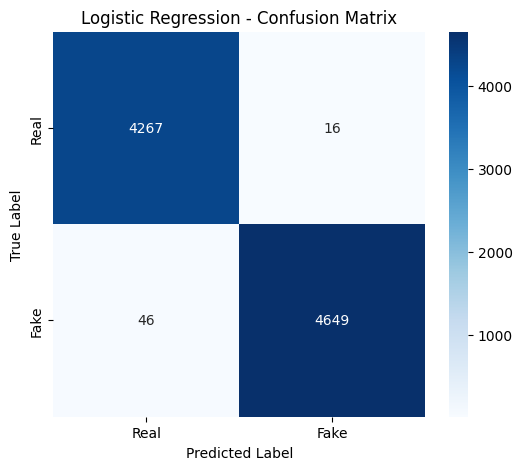


Linear SVM - RESULTS
Accuracy : 0.9972
Precision: 0.9985
Recall   : 0.9962
F1 Score : 0.9973

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4283
        Fake       1.00      1.00      1.00      4695

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



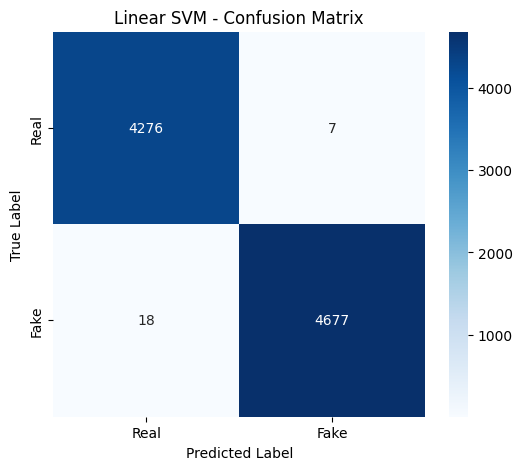

In [52]:
lr_results = evaluate_model("Logistic Regression", lr, X_test_tfidf, y_test)
svm_results = evaluate_model("Linear SVM", svm, X_test_tfidf, y_test)

In [53]:
print("\nPreparing data for Deep Learning...")
tokenizer_dl = Tokenizer(num_words=10000)
tokenizer_dl.fit_on_texts(X_train)
X_train_seq = tokenizer_dl.texts_to_sequences(X_train)
X_test_seq = tokenizer_dl.texts_to_sequences(X_test)
X_train_dl = pad_sequences(X_train_seq, maxlen=200)
X_test_dl = pad_sequences(X_test_seq, maxlen=200)
print(f"DL training shape: {X_train_dl.shape}")
print(f"DL test shape: {X_test_dl.shape}")


Preparing data for Deep Learning...
DL training shape: (35911, 200)
DL test shape: (8978, 200)


In [54]:
print("\nBuilding BiLSTM model...")

dl_model = Sequential([
    Embedding(10000, 128, input_length=200),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3)),
    Bidirectional(LSTM(32, dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

dl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print(dl_model.summary())


Building BiLSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None



Training BiLSTM model...
Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 461s 944ms/step - accuracy: 0.8705 - loss: 0.2726 - precision: 0.8547 - recall: 0.9222 - val_accuracy: 0.9731 - val_loss: 0.0860 - val_precision: 0.9956 - val_recall: 0.9531 - learning_rate: 0.0010
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 396s 831ms/step - accuracy: 0.9830 - loss: 0.0556 - precision: 0.9847 - recall: 0.9829 - val_accuracy: 0.9688 - val_loss: 0.0940 - val_precision: 0.9632 - val_recall: 0.9781 - learning_rate: 0.0010
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 447s 841ms/step - accuracy: 0.9821 - loss: 0.0521 - precision: 0.9832 - recall: 0.9826 - val_accuracy: 0.9866 - val_loss: 0.0390 - val_precision: 0.9901 - val_recall: 0.9845 - learning_rate: 0.0010
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 393s 824ms/step - accuracy: 0.9938 - loss: 0.0193 - precision: 0.9951 - recall: 0.9932 - val_accuracy: 0.9850 - val_loss: 0.0435 - val_precision: 0.9835 - val_recall: 0.9880 - learning_rate: 0.0010
Epoch 5/10
477/477 ━━━

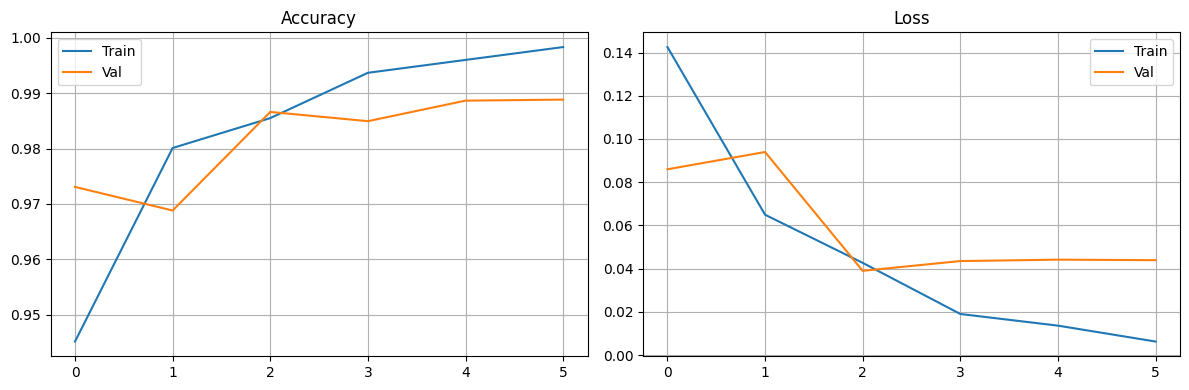

In [55]:
print("\nTraining BiLSTM model...")

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = dl_model.fit(
    X_train_dl,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


BiLSTM - RESULTS
Accuracy : 0.9876
Precision: 0.9877
Recall   : 0.9887
F1 Score : 0.9882

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4283
        Fake       0.99      0.99      0.99      4695

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



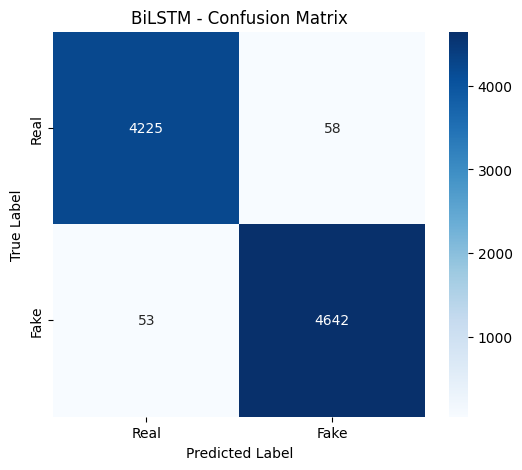

In [56]:
y_pred_dl = (dl_model.predict(X_test_dl, verbose=0) > 0.5).astype(int).flatten()

dl_results = evaluate_model("BiLSTM",
                           type('Model', (), {'predict': lambda self, X: y_pred_dl})(),
                           X_test_dl, y_test)


MODEL COMPARISON
                     accuracy  precision    recall        f1
Logistic Regression  0.993094   0.996570  0.990202  0.993376
Linear SVM           0.997215   0.998506  0.996166  0.997334
BiLSTM               0.987636   0.987660  0.988711  0.988185


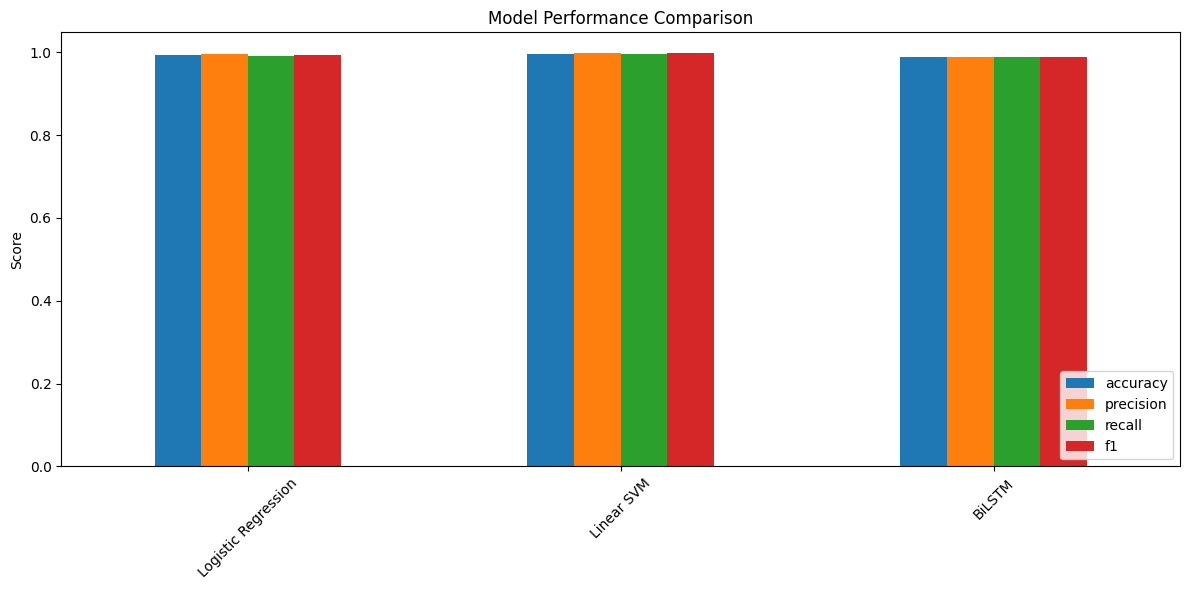

In [57]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Logistic Regression': lr_results,
    'Linear SVM': svm_results,
    'BiLSTM': dl_results
}).T

print(comparison)

comparison.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [58]:
print("\nSaving models...")
os.makedirs("models", exist_ok=True)

joblib.dump(lr, "models/lr_model.pkl")
joblib.dump(svm, "models/svm_model.pkl")
joblib.dump(tfidf, "models/tfidf.pkl")
joblib.dump(tokenizer_dl, "models/tokenizer_dl.pkl")
dl_model.save("models/bilstm_model.h5")

print("All models saved!")


Saving models...


All models saved!


In [68]:
def predict_news(title, text, model_type='svm'):
    """Predict if news is fake or real"""
    combined = preprocess_text(title + " " + text)

    if model_type == 'dl':
        seq = tokenizer_dl.texts_to_sequences([combined])
        padded = pad_sequences(seq, maxlen=200)
        pred = int((dl_model.predict(padded, verbose=0) > 0.5)[0][0])
    else:
        text_vec = tfidf.transform([combined])
        if model_type == 'lr':
            pred = lr.predict(text_vec)[0]
        else:
            pred = svm.predict(text_vec)[0]

    return "FAKE" if pred == 1 else "REAL"

# Test prediction
print("\n" + "="*60)
print("TEST PREDICTION")
print("="*60)

#  Enter the title here and Text of the news in the Test_text variable.
test_title = "Israel Fullfilled one more prophecy"
test_text = """ Israel slaughtered the red heifer as they start the building of temple of solomon"""

print(f"\nTitle: {test_title}")
print(f"Text: {test_text}")
print(f"\nLogistic Regression: {predict_news(test_title, test_text, 'lr')}")
print(f"SVM: {predict_news(test_title, test_text, 'svm')}")
print(f"BiLSTM: {predict_news(test_title, test_text, 'dl')}")

print("\n All done!")


TEST PREDICTION

Title: Israel Fullfilled one more prophecy
Text:  Israel slaughtered the red heifer as they start the building of temple of solomon

Logistic Regression: FAKE
SVM: FAKE
BiLSTM: FAKE

 All done!


cp: cannot stat '*.ipynb': No such file or directory


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>